In [ ]:
# 웹 크롤링 + csv 파일 생성

import requests
import pandas as pd
import re
from bs4 import BeautifulSoup
import time
import random

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"}

# 읽을 페이지 범위
start_page = 1669
end_page = 0

page_num = start_page

while page_num >= end_page:
    url = f"https://gall.dcinside.com/board/lists/?id=dcbest&list_num=100&sort_type=N&search_head=1&page={page_num}"

    try:
        # 요청
        respons = requests.get(url, headers=headers)
        respons.raise_for_status()  # HTTP 오류가 발생한 경우 예외를 발생시킴
        
        html = respons.text
        soup = BeautifulSoup(html, 'html.parser')
        rows = soup.find_all('tr', attrs={"class": "ub-content us-post thum"})
        print(f"응답완료 {page_num} 추출")
        
    except requests.exceptions.RequestException as e:
        # 요청 실패 시의 페이지 번호와 함께 오류 출력
        print(f"요청 실패: {page_num} 페이지에서 오류 발생")
        print(f"오류 내용: {e}")
        # 요청 실패 후 대기하고 다시 시도
        time.sleep(random.uniform(5, 10))  # 5~10초 대기 후 재시도
        continue  # 예외 발생 시 현재 페이지 번호로 다시 시도

    data = []

    for row in rows:
        columns = row.find_all('td')
        #td 텍스트 추출 후 리스트로 저장
        row_data = [column.get_text(strip=True) for column in columns] 
        # 모든 데이터를 하나의 리스트로 추가 
        data.extend(row_data)  

    # 컬럼 2개를 추가하기 위해 새로운 리스트로 변경
    chunked_data = [data[i:i+6] for i in range(0, len(data), 6)]

    for row in chunked_data:
        # [갤러리] 제목 [댓글수] 형태를 분리하는 정규식
        match = re.match(r"\[(.*?)\](.*?)\[(.*?)\]$", row[1])
        if match:
		        # '갤러리' 부분, 대괄호 제거
            row[1] = match.group(1).strip() 
            # '제목' 부분 
            row.insert(2, match.group(2).strip())  
            # '댓글수' 부분, 대괄호 제거
            row.insert(3, match.group(3).strip())  

    # DataFrame 생성 
    df = pd.DataFrame(chunked_data, columns=["글번호", "갤러리", "제목", "댓글수", "작성자", "작성날짜", "조회수", "추천수"])
    
    # 첫 번째 반복에서만 파일을 새로 생성
    if page_num == start_page:
        df.to_csv('dcinside_data.csv', index=False, encoding='utf-8-sig')
    else:
        # 이후 반복에서는 기존 CSV 파일에 추가
        df.to_csv('dcinside_data.csv', mode='a', header=False, index=False, encoding='utf-8-sig')

    # 1~5초 대기
    time.sleep(random.uniform(1, 5))

    # 다음 페이지로 이동
    page_num -= 1


In [3]:
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# 데이터 읽기
df = pd.read_csv("dcinside_data.csv")
df = df.dropna()
df.shape

(158375, 8)

# 이미지클라우드
## 너무 많이 나오는 단어는 뺌


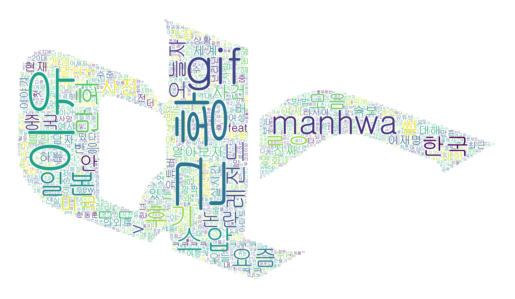

In [ ]:
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# 데이터 읽기
df = pd.read_csv("dcinside_data.csv")
text = ' '.join(df['제목'].dropna().astype(str).apply(lambda x: re.sub(r'(?i)jpg|gif|싱글벙글|후기|훌쩍훌쩍|근황|오싹오싹|스압|이유', '', x)))

# 이미지 불러오기 + 해상도 설정
icon = Image.open('./dcinside.png').resize((3840,2160))    

# 이미지를 RGBA 모드로 변환
icon = icon.convert("RGBA")

# 이미지를 numpy 배열로 변환
icon_data = np.array(icon)

# 흰색 부분을 마스크로 사용 (흰색 부분을 불투명하고, 나머지 부분은 투명하게 설정)
mask_data = np.all(icon_data[:, :, :3] == [255, 255, 255], axis=-1)

# 마스크를 생성: 흰색 부분은 255 (불투명), 나머지 부분은 0 (투명)
icon_data[mask_data] = [0, 0, 0, 255]  # 흰색 부분을 불투명하게 설정
icon_data[~mask_data] = [255, 255, 255, 0]  # 나머지 부분을 투명하게 설정

# 수정된 이미지를 다시 이미지 객체로 변환
mask = Image.fromarray(icon_data)

# PIL 이미지를 numpy 배열로 변환
mask_array = np.array(mask)

# 제목 열을 바로 워드 클라우드에 전달하여 텍스트 생성
wordcloud = WordCloud(font_path="C:\\Windows\\Fonts\\gulim.ttc", 
                      collocations=False,  #자주 등장하는 단어들 제외 false
                      max_words= 2000,
                      max_font_size = 500,
                      background_color='white', 
                       mask = mask_array
                      ).generate(text)

# 워드 클라우드 표시
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## 무수정 이미지 
## 크기줄임 최대 글자수 줄임 
## jpg와 싱글벙글이 너무 영향력이 큼

(1080, 1980, 4)


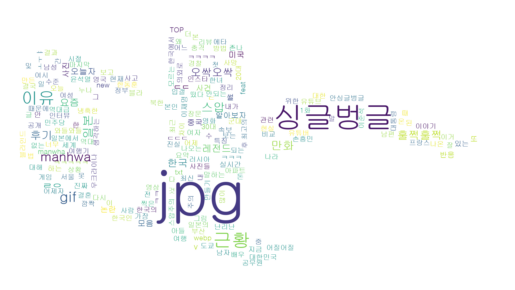

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# 데이터 읽기
df = pd.read_csv("dcinside_data.csv")
text = ' '.join(df['제목'].dropna().astype(str))

icon = Image.open('./dcinside.png').resize((1980,1080))    

# 이미지를 RGBA 모드로 변환
icon = icon.convert("RGBA")

# 이미지를 numpy 배열로 변환
icon_data = np.array(icon)

# 흰색 부분을 마스크로 사용 (흰색 부분을 불투명하고, 나머지 부분은 투명하게 설정)
mask_data = np.all(icon_data[:, :, :3] == [255, 255, 255], axis=-1) 

# 마스크를 생성: 흰색 부분은 255 (불투명), 나머지 부분은 0 (투명)
icon_data[mask_data] = [0, 0, 0, 255] 
icon_data[~mask_data] = [255, 255, 255, 0]  

# 수정된 이미지를 다시 이미지 객체로 변환
mask = Image.fromarray(icon_data)

# PIL 이미지를 numpy 배열로 변환 (WordCloud는 NumPy 배열을 필요로 함)
mask_array = np.array(mask)

# 제목 열을 바로 워드클라우드에 전달하여 텍스트 생성
wordcloud = WordCloud(font_path="C:\\Windows\\Fonts\\gulim.ttc", 
                      collocations=False,  #자주 등장하는 단어들 제외 false
                      max_font_size = 1000,
                      min_font_size=10,
                      background_color='white', 
                       mask = mask_array
                      ).generate(text)

# 워드 클라우드 표시
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


(1080, 1980, 4)


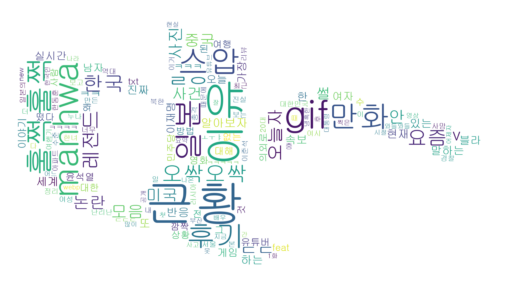

In [ ]:
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# 데이터 읽기
df = pd.read_csv("dcinside_data.csv")
text = ' '.join(df['제목'].dropna().astype(str).apply(lambda x: re.sub(r'(?i)jpg|싱글벙글', '', x)))

icon = Image.open('./dcinside.png').resize((1980,1080))    # 마스크가 될 이미지 불러오기 

# 이미지를 RGBA 모드로 변환 (알파 채널을 추가)
icon = icon.convert("RGBA")

# 이미지를 numpy 배열로 변환
icon_data = np.array(icon)

# 흰색 부분을 마스크로 사용 (흰색 부분을 불투명하고, 나머지 부분은 투명하게 설정)
mask_data = np.all(icon_data[:, :, :3] == [255, 255, 255], axis=-1)  # 흰색 부분 찾기

# 마스크를 생성: 흰색 부분은 255 (불투명), 나머지 부분은 0 (투명)
icon_data[mask_data] = [0, 0, 0, 255]  # 흰색 부분을 불투명하게 설정
icon_data[~mask_data] = [255, 255, 255, 0]  # 나머지 부분을 투명하게 설정

# 수정된 이미지를 다시 이미지 객체로 변환
mask = Image.fromarray(icon_data)

# PIL 이미지를 numpy 배열로 변환 (WordCloud는 NumPy 배열을 필요로 함)
mask_array = np.array(mask)

# 제목 열을 바로 워드 클라우드에 전달하여 텍스트 생성
wordcloud = WordCloud(font_path="C:\\Windows\\Fonts\\gulim.ttc", 
                      collocations=False,  #자주 등장하는 단어들 제외 false
   
                      max_font_size = 1000,
                      min_font_size=20,
                      background_color='white', 
                       mask = mask_array
                      ).generate(text)

# 워드 클라우드 표시
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# 제목에서 단어 뽑아내기

In [ ]:
import pandas as pd
from konlpy.tag import Okt
from collections import defaultdict

# CSV 파일 읽기
df = pd.read_csv('dcinside_data.csv')

# Okt 객체 생성
okt = Okt()

# 중복 처리 및 명사별 조회수, 추천수 합산을 위한 딕셔너리 초기화
noun_info = defaultdict(lambda: {'count': 0, 'view': 0, 'recommend': 0})

# 제목 열에서 명사 추출 중복처리와 동시에 조회수, 추천수 합산
for _, row in df.iterrows():
    title = str(row['제목'])  # 제목을 문자열로 변환
    views = row['조회수']
    recommends = row['추천수']
    
    # 제목이 NaN이거나 빈 문자열이면 처리하지 않도록 skip
    if title.strip() == '':
        continue
    
    # 제목에서 명사 추출
    nouns = okt.nouns(title)
    
    # 명사별로 중복횟수와 조회수, 추천수 업데이트
    for noun in nouns:
        noun_info[noun]['count'] += 1
        noun_info[noun]['view'] += views
        noun_info[noun]['recommend'] += recommends

# 중복 처리된 명사들로 새로운 데이터프레임 생성
result_data = []
for noun, data in noun_info.items():
    result_data.append([noun, data['count'], data['view'], data['recommend']])

# 새로운 데이터프레임 생성
result_df = pd.DataFrame(result_data, columns=['명사', '중복횟수', '총조회수', '총추천수'])

#정렬
df_sort_by_view_count = result_df.sort_values(by='총조회수', ascending=False)
df_sort_by_word_count = result_df.sort_values(by='중복횟수', ascending=False)

# CSV 파일로 저장
df_sort_by_view_count.to_csv("df_sort_by_view_count.csv")
df_sort_by_word_count.to_csv("df_sort_by_word_count.csv")

# dcinside_data에 긍정도 붙이기

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 한국어 모델 로드
model_name = "beomi/KcELECTRA-base"  
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 모델이 GPU에 로드되었는지 확인
print(next(model.parameters()).device)  # 'cuda:0'이 출력되면 GPU에 로드된 것

# CSV 파일 읽기
df = pd.read_csv('dcinside_data.csv')
df = df.dropna()

# 제목 열을 가져와서 배치 처리하는 함수
def batch_analyze_sentiment(titles, batch_size=1024):
    # 텍스트를 배치로 나누어 토큰화
    inputs = tokenizer(titles, padding=True, truncation=True, return_tensors="pt")
    # 데이터를 GPU로 이동
    inputs = {key: value.to(device) for key, value in inputs.items()}  

    # inputs가 GPU에 있는지 확인 cuda:0이 GPU에서 실행되고 있음
    print(inputs['input_ids'].device)  
    
		# 불필요한 그래디언트 계산을 피하기 위해
    with torch.no_grad():  
        outputs = model(**inputs)
         # 예측 결과는 GPU에서 반환됨
        predictions = torch.argmax(outputs.logits, dim=-1) 
    
    return predictions

# 데이터프레임의 제목 열을 배치로 나누어 감정 분석 실행
batch_size = 1024
titles = df['제목'].tolist()

# 배치로 나누어 처리
predictions = []
for i in range(0, len(titles), batch_size):
    batch_titles = titles[i:i+batch_size]
    print(batch_titles)
    batch_predictions = batch_analyze_sentiment(batch_titles)
    
    # GPU에서 직접 처리된 결과를 그대로 사용
     # 텐서를 리스트로 변환하여 추가
    predictions.extend(batch_predictions.tolist()) 

# 결과를 긍정 컬럼 값으로 변환 (긍정은 1, 부정은 0)
df['긍정'] = [1 if pred == 1 else 0 for pred in predictions]

# 새로운 CSV 파일로 저장
df.to_csv('dcinside_new_data.csv', index=False)
# 기존 csv 파일로 저장
#df.to_csv('dcinside_data.csv', index=False)

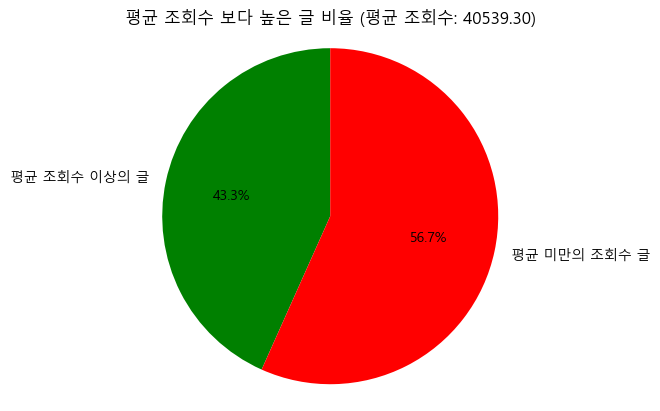

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

# 한글 폰트 설정 (Windows의 경우 "Malgun Gothic" 사용, Mac의 경우 "AppleGothic" 사용)
rc('font', family='Malgun Gothic')  # 'NanumGothic' 폰트로 설정

# 1. 데이터 불러오기
df = pd.read_csv('dcinside_data.csv')

# 2. 조회수 평균 계산
average_views = df['조회수'].mean()

# 3. 평균 이상과 이하의 글 구분
above_average = df[df['조회수'] >= average_views]
below_average = df[df['조회수'] < average_views]

# 4. 비율 계산
above_average_ratio = len(above_average) / len(df)
below_average_ratio = len(below_average) / len(df)

# 5. 원형 그래프 그리기
ratios = [above_average_ratio, below_average_ratio]
categories = ['평균 조회수 이상의 글', '평균 미만의 조회수 글']
colors = ['green', 'red']

# 그래프 그리기
plt.pie(ratios, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'평균 조회수 보다 높은 글 비율 (평균 조회수: {average_views:.2f})')
plt.axis('equal')  # 원이 왜곡되지 않도록 유지

# 그래프 표시
plt.show()


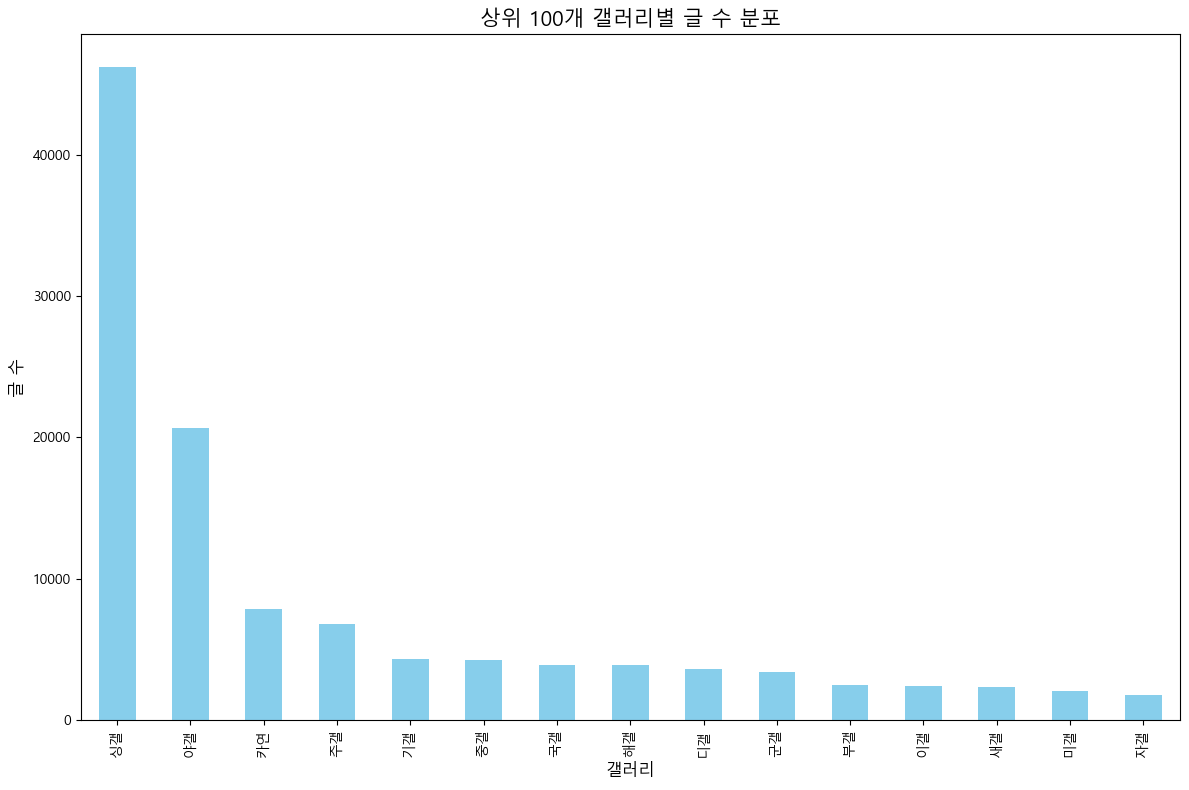

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df = pd.read_csv('dcinside_data.csv')

# 2. 갤러리별 글 수 계산 (갤러리 열을 기준으로 카운트)
gallery_counts = df['갤러리'].value_counts()

# 3. 상위 100개 갤러리만 선택
top_100_galleries = gallery_counts.head(15)

# 4. 상위 100개 갤러리 글 수 분포도 시각화
plt.figure(figsize=(12, 8))  # 그래프 크기 설정
top_100_galleries.plot(kind='bar', color='skyblue')
plt.title('상위 100개 갤러리별 글 수 분포', fontsize=15)
plt.xlabel('갤러리', fontsize=12)
plt.ylabel('글 수', fontsize=12)
plt.xticks(rotation=90)  # x축 레이블이 겹치지 않도록 90도로 회전
plt.tight_layout()  # 레이아웃 조정 (x축 레이블이 잘리거나 겹치지 않게)
plt.show()


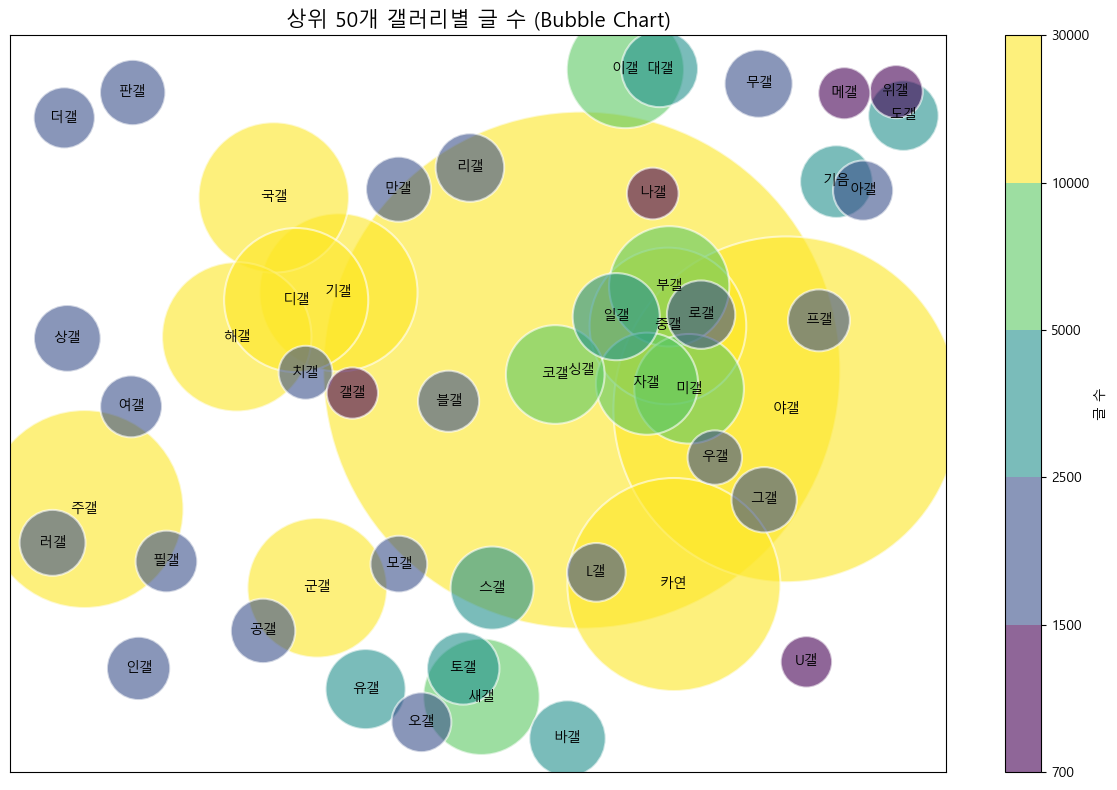

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm

# 1. 데이터 불러오기
df = pd.read_csv('dcinside_data.csv')

# 2. 갤러리별 글 수 계산 (갤러리 열을 기준으로 카운트)
gallery_counts = df['갤러리'].value_counts()

# 3. 상위 50개 갤러리만 선택
top_30_galleries = gallery_counts.head(50)

# 4. 원의 크기 설정 (글 수에 비례)
sizes = top_30_galleries.values * 3  # 글 수에 비례해 크기 설정 (3을 곱해 크기 조정)

# 5. 랜덤 배치를 위한 x, y 좌표 설정
x_positions = np.random.rand(len(top_30_galleries)) * 100  # x 좌표를 랜덤하게 설정 (0~100 범위)
y_positions = np.random.rand(len(top_30_galleries)) * 100  # y 좌표를 랜덤하게 설정 (0~100 범위)

# 6. 색상 설정 (버블의 크기에 따라 채도가 다르게 설정)
# 색상은 원의 크기(sizes)에 비례하여 설정
boundaries = [700,1500,2500, 5000, 10000, 30000]  # 오름차순으로 정렬된 구간
cmap = plt.get_cmap("viridis")  # 색상 맵을 viridis로 변경 (눈에 띄는 색상)
norm = BoundaryNorm(boundaries, cmap.N)  # BoundaryNorm을 사용해 구간을 설정

# 7. Bubble Chart 그리기
plt.figure(figsize=(12, 8))  # 그래프 크기 설정

# 8. 각 원 그리기 (크기와 색상 설정)
scatter = plt.scatter(x_positions, y_positions, s=sizes, c=sizes, cmap=cmap, alpha=0.6, edgecolors="w", linewidth=1.5, norm=norm)

# 9. 색상 바 (컬러맵에 대한 범위 표시)
plt.colorbar(scatter, label='글 수')

# 10. 각 버블 안에 갤러리 이름 넣기
for i, (x, y, size, gallery) in enumerate(zip(x_positions, y_positions, sizes, top_30_galleries.index)):
    plt.text(x, y, gallery, ha='center', va='center', fontsize=10, color='black')

# 11. 그래프 설정
plt.title('상위 50개 갤러리별 글 수 (Bubble Chart)', fontsize=15)
plt.xticks([])  # x축 레이블 숨기기
plt.yticks([])  # y축 레이블 숨기기
plt.tight_layout()  # 레이아웃 조정

# 12. 그래프 표시
plt.show()

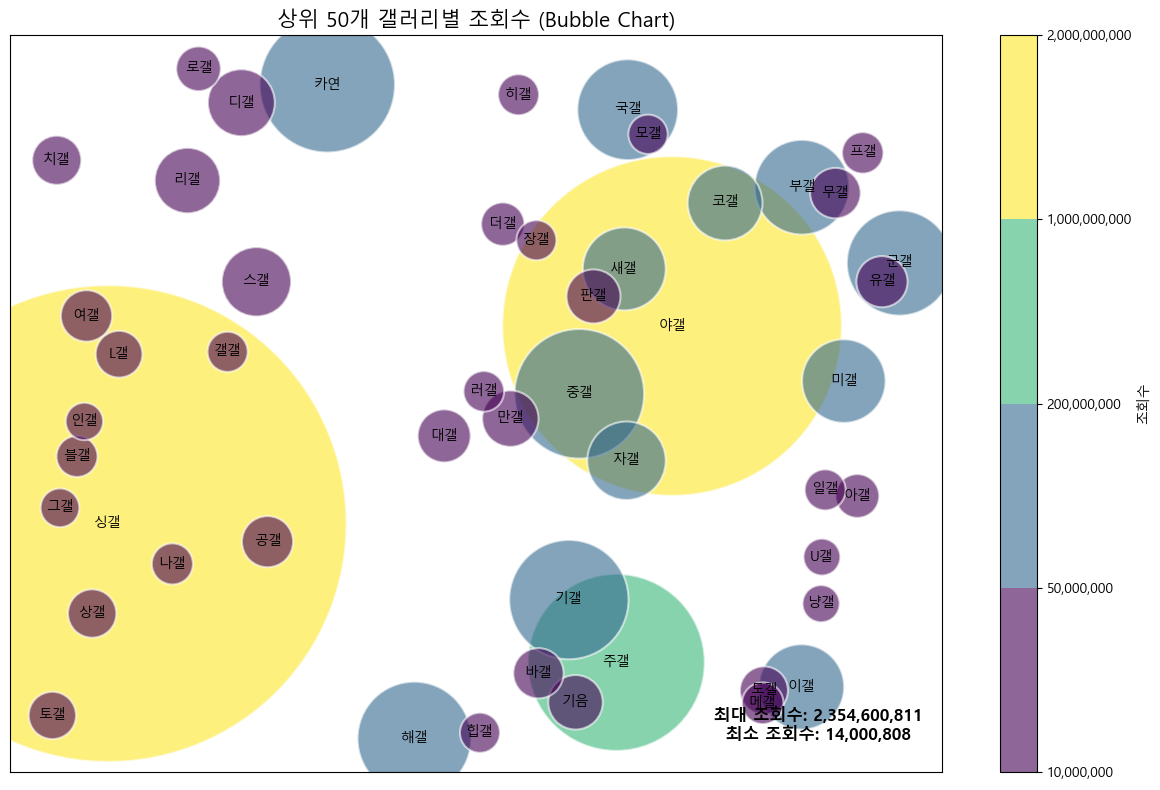

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import FuncFormatter

# 1. 데이터 불러오기
df = pd.read_csv('dcinside_data.csv')

# 2. 갤러리별 조회수 합산
gallery_counts = df.groupby('갤러리')['조회수'].sum().sort_values(ascending=False)

# 3. 상위 50개 갤러리만 선택
top_50_galleries = gallery_counts.head(50)

# 4. 원의 크기 설정 (조회수에 비례)
sizes = top_50_galleries.values * 0.00005  # 조회수에 비례해 크기 설정 (크기 조정)

# 5. 랜덤 배치를 위한 x, y 좌표 설정
x_positions = np.random.rand(len(top_50_galleries)) * 100  # x 좌표를 랜덤하게 설정 (0~100 범위)
y_positions = np.random.rand(len(top_50_galleries)) * 100  # y 좌표를 랜덤하게 설정 (0~100 범위)

# 6. 색상 설정 (조회수에 따라 색상이 다르게 설정)
# 조회수 구간을 최대값(20억)과 최소값(천만)에 맞춰 설정
boundaries = [10000000, 50000000, 200000000, 1000000000, 2000000000]  # 조회수 구간 설정
cmap = plt.get_cmap("viridis")  # 색상 맵 (viridis 사용)
norm = BoundaryNorm(boundaries, cmap.N)  # BoundaryNorm을 사용해 구간을 설정

# 7. Bubble Chart 그리기
plt.figure(figsize=(12, 8))  # 그래프 크기 설정

# 8. 각 원 그리기 (크기와 색상 설정)
scatter = plt.scatter(x_positions, y_positions, s=sizes, c=top_50_galleries.values, cmap=cmap, alpha=0.6, edgecolors="w", linewidth=1.5, norm=norm)

# 9. 색상 바 (컬러맵에 대한 범위 표시)
cbar = plt.colorbar(scatter, label='조회수')

# 10. colorbar 레이블을 일반 숫자 형식으로 변경
def format_ticks(x, pos):
    return f'{int(x):,}'  # 천 단위 구분 기호를 추가하여 숫자 포맷

cbar.formatter = FuncFormatter(format_ticks)
cbar.update_ticks()  # colorbar의 레이블 업데이트

# 11. 각 버블 안에 갤러리 이름 넣기
for i, (x, y, size, gallery) in enumerate(zip(x_positions, y_positions, sizes, top_50_galleries.index)):
    plt.text(x, y, gallery, ha='center', va='center', fontsize=10, color='black')

# 12. 최대, 최소 조회수 텍스트 추가 (제목 옆에 위치)
max_views = top_50_galleries.max()
min_views = top_50_galleries.min()

plt.text(90, 3, f'최대 조회수: {int(max_views):,}', ha='center', va='bottom', fontsize=12, color='black', weight='bold')
plt.text(90, 0.5, f'최소 조회수: {int(min_views):,}', ha='center', va='bottom', fontsize=12, color='black', weight='bold')

# 13. 그래프 설정
plt.title('상위 50개 갤러리별 조회수 (Bubble Chart)', fontsize=15)
plt.xticks([])  # x축 레이블 숨기기
plt.yticks([])  # y축 레이블 숨기기
plt.tight_layout()  # 레이아웃 조정

# 14. 그래프 표시
plt.show()

# 15. 상위 50개 갤러리 리스트를 print로 출력
print("상위 50개 갤러리 목록:")
for idx, gallery in enumerate(top_50_galleries.index, start=1):
    print(f"{gallery}")


In [ ]:
# 날짜별 각 갤러리 글의 총 조회수

import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

# Plotly를 브라우저에서 출력하도록 설정
pio.renderers.default = "browser"

# 데이터프레임 읽기
df = pd.read_csv("dcinside_data.csv")
df = df.dropna()  # 결측값이 있는 행 삭제

# 작성날짜 포맷 수정 (월.일 -> 24.월.일로 수정)
def fix_date_format(date):
    if ':' in date:  # 시간(:)이 포함된 경우
        return "24." + date.split()[0][2:]  # "24.11.12" 형식으로 변경
    elif len(date) == 5:  # "월.일" 형식일 경우
        return "24." + date
    return date

df['작성날짜'] = df['작성날짜'].apply(fix_date_format)

# 작성날짜를 '년.월.일' 형식으로 변환, errors='coerce'를 추가하여 변환할 수 없는 값은 NaT로 처리
df['작성날짜'] = pd.to_datetime(df['작성날짜'], format='%y.%m.%d', errors='coerce')

# 변환할 수 없는 날짜가 있는 행 삭제
df = df.dropna(subset=['작성날짜'])

# 필터링할 갤러리 리스트
selected_galleries = [
    "싱갤", "야갤", "주갤", "카연", "중갤", "기갤", "해갤", "군갤", "국갤", "부갤",
    "이갤", "미갤", "새갤", "자갤", "코갤", "스갤", "디갤", "리갤", "만갤", "기음",
    "판갤", "대갤", "여갤", "유갤", "공갤", "무갤", "바갤", "치갤", "상갤", "도갤",
    "토갤", "L갤", "로갤", "아갤", "더갤", "메갤", "프갤", "나갤", "블갤", "일갤",
    "히갤", "러갤", "갤갤", "힙갤", "장갤", "모갤", "그갤", "인갤", "냥갤", "U갤"
]

# 조회수를 갤러리별로 합산하여 각 날짜별로 그룹화
df_grouped = df.groupby(['작성날짜', '갤러리'], as_index=False)['조회수'].sum()

# 선택된 갤러리들만 필터링
df_grouped_filtered = df_grouped[df_grouped['갤러리'].isin(selected_galleries)].copy()

print(df_grouped_filtered.head(40))

# 조회수를 로그 변환하여 더 작은 범위로 조정 (로그 변환 후 크기 조정)
# df_grouped_filtered['log_조회수'] = np.log1p(df_grouped_filtered['조회수'])

# Plotly로 Scatter 그래프 생성
fig = px.scatter(
    df_grouped_filtered,
    x='갤러리',
    y='조회수',
    color='갤러리',
    size='조회수',  # 로그 변환된 조회수를 사용하여 점의 크기 결정
    animation_frame='작성날짜',
    animation_group='갤러리',
    title="갤러리별 조회수 변화 (상위 50개)",
    labels={"작성날짜": "작성 날짜", "조회수": "조회수"},
    size_max=50,  # 점의 최대 크기 제한
)

# 그래프를 HTML 파일로 저장 (웹에서 열 수 있도록)
fig.write_html("dcinside_top50_scatter_plot.html")

# 웹 브라우저에서 열기
fig.show()


In [20]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 데이터프레임 읽기
df = pd.read_csv('df_sort_by_view_count.csv')

# 데이터가 제대로 로드되었는지 확인
print(df.head())

# 1. 총추천수가 가장 높은 20개 명사 (총추천수 기준으로 상위 20개 선택)
top_recommended = df.nlargest(20, '총추천수')

# 2. 총조회수가 가장 높은 20개 명사 (이미 정렬되어 있으므로, 상위 20개 선택)
top_viewed = df.nlargest(20, '총조회수')

# 

# 총추천수, 총조회수, 중복횟수 비교 그래프 생성 (총조회수는 막대, 추천수와 중복횟수는 점)
fig = make_subplots(
    rows=1, cols=1, 
    specs=[[{'secondary_y': True}]],  # secondary y-axis를 사용
    subplot_titles=['조회수, 추천수, 중복횟수 비교 (상위 20개 명사)']
)

# 총조회수 (막대그래프)
fig.add_trace(
    go.Bar(
        x=top_viewed['명사'],
        y=top_viewed['총조회수'],
        name='총조회수',
        text=top_viewed['총조회수'],  # 막대 위에 조회수 표시
    ),
    secondary_y=False,  # 첫 번째 y축
)

# 총추천수 (점그래프)
fig.add_trace(
    go.Scatter(
        x=top_viewed['명사'],
        y=top_viewed['총추천수'],
        mode='markers',
        name='총추천수',
        marker=dict(size=10),
        text=top_viewed['총추천수'],  # 점 위에 추천수 표시
    ),
    secondary_y=True,  # 두 번째 y축
)

# 중복횟수 (점그래프)
fig.add_trace(
    go.Scatter(
        x=top_viewed['명사'],
        y=top_viewed['중복횟수'],
        mode='markers',
        name='중복횟수',
        marker=dict(size=10),
        text=top_viewed['중복횟수'],  # 점 위에 중복횟수 표시
    ),
    secondary_y=True,  # 두 번째 y축
)

# Layout 설정
fig.update_layout(
    title='조회수, 추천수, 중복횟수 비교 그래프 (상위 20개 명사)',
    xaxis_title='명사',
    yaxis_title='총조회수',
    showlegend=True,
    xaxis=dict(tickangle=45),
)

# 첫 번째 y축 (총조회수)
fig.update_yaxes(
    title_text='총조회수',
    secondary_y=False,
    tickmode='array',
    tickvals=[10000, 100000, 1000000, 10000000, 100000000],  # 주요 값들에 대해 표시할 값 설정
    ticktext=['1만', '10만', '100만', '1천만', '1억']  # 각 값에 해당하는 텍스트 표시
)

# 두 번째 y축 (총추천수, 중복횟수)
fig.update_yaxes(
    title_text='추천수, 중복횟수',
    secondary_y=True,
    tickmode='array',
    tickvals=[1000, 10000, 100000, 1000000],  # 주요 값들에 대해 표시할 값 설정
    ticktext=['1천', '1만', '10만', '100만'],  # 각 값에 해당하는 텍스트 표시
)

   Unnamed: 0    명사   중복횟수          총조회수        총추천수
0          13  싱글벙글  30335  1.556984e+09  16550106.0
1         162    근황   8135  4.483345e+08   5372012.0
2         117    이유   6549  3.267751e+08   4068801.0
3         409    훌쩍   5171  2.725097e+08   3257399.0
4          43    한국   4880  2.322830e+08   2968355.0


In [22]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 데이터프레임 읽기
df_w = pd.read_csv('df_sort_by_word_count.csv')
df_v = pd.read_csv('df_sort_by_view_count.csv')

# 데이터가 제대로 로드되었는지 확인
print(df.head())


top_viewed = df_v.nlargest(21, '총조회수')
top_viewed = top_viewed[1:21]


# 총추천수, 총조회수, 중복횟수 비교 그래프 생성 (서브플롯 추가)
fig = make_subplots(
    rows=2, cols=1,  # 2개의 행, 1개의 열
    specs=[[{'secondary_y': True}], [{'secondary_y': False}]],  # 첫 번째 플롯: secondary y축, 두 번째 플롯: 단일 y축
    subplot_titles=['조회수와 추천수 비교 (상위 20개 명사 - 상위 1개 제외)', '중복횟수 비교'],
    vertical_spacing=0.2  # 그래프 간의 간격 설정 (기본값은 0.1)
)


# 총조회수 (막대그래프)
fig.add_trace(
    go.Bar(
        x=top_viewed['명사'],
        y=top_viewed['총조회수'],
        name='총조회수',
        text=top_viewed['총조회수'],  # 막대 위에 조회수 표시
        marker=dict()
    ),
    row=1, col=1,  # 첫 번째 행, 첫 번째 열
    secondary_y=False,  # 첫 번째 y축
)

# 총추천수 (점그래프)
fig.add_trace(
    go.Scatter(
        x=top_viewed['명사'],
        y=top_viewed['총추천수'],
        mode='markers',
        name='총추천수',
        marker=dict(size=10),
        text=top_viewed['총추천수'],  # 점 위에 추천수 표시
    ),
    row=1, col=1,  # 첫 번째 행, 첫 번째 열
    secondary_y=True,  # 두 번째 y축
)


# 중복횟수 (꺾은선 그래프)
fig.add_trace(
    go.Scatter(
        x=top_viewed['명사'],
        y=top_viewed['중복횟수'],
        mode='lines+markers',
        name='중복횟수',
        line=dict(color='green', width=2),
        marker=dict(size=8, color='green'),
        text=top_viewed['중복횟수'],  # 점 위에 중복횟수 표시
    ),
    row=2, col=1  # 두 번째 행, 첫 번째 열
)


# 전체 레이아웃 설정
fig.update_layout(
    title='조회수, 추천수, 중복횟수 비교',
    xaxis_title='명사',
    showlegend=True,
    height=800,  # 전체 그래프 높이 조정
)

# 첫 번째 플롯의 y축 설정
fig.update_yaxes(
    title_text='총조회수',
    secondary_y=False,
    row=1, col=1
)
fig.update_yaxes(
    title_text='추천수',
    secondary_y=True,
    row=1, col=1
)

# 두 번째 플롯의 y축 설정 (중복횟수 전용)
fig.update_yaxes(
    title_text='중복횟수',
    row=2, col=1
)

# x축 설정 (모든 플롯에 동일 적용)
fig.update_xaxes(
    title_text='명사',
    tickangle=45,
    row=1, col=1  # 첫 번째 플롯
)
fig.update_xaxes(
    title_text='명사',
    tickangle=45,
    row=2, col=1  # 두 번째 플롯
)

# 그래프 출력
fig.show()


   Unnamed: 0    명사   중복횟수          총조회수        총추천수
0          13  싱글벙글  30335  1.556984e+09  16550106.0
1         162    근황   8135  4.483345e+08   5372012.0
2         117    이유   6549  3.267751e+08   4068801.0
3         409    훌쩍   5171  2.725097e+08   3257399.0
4          43    한국   4880  2.322830e+08   2968355.0


In [28]:
import pandas as pd
import plotly.express as px

# 데이터프레임 읽기
df_w = pd.read_csv('df_sort_by_word_count.csv')
df_v = pd.read_csv('df_sort_by_view_count.csv')

# 3. 중복횟수가 가장 높은 20개 명사
top_duplicate = df_w.nlargest(41, '중복횟수')
row_duplicate = df_w.nsmallest(1000, '중복횟수')

top_viewed = df_v.nlargest(41, '총조회수')
row_viewed = df_v.nsmallest(40, '총조회수')

# 1. 총추천수가 가장 높은 20개 명사 (총추천수 기준으로 상위 20개 선택)
top_recommended = df_w.nlargest(41, '총추천수')
row_recommended = df_w.nsmallest(40, '총추천수')

# 중복횟수 높은 40개 단어
fig_duplicate = px.bar(
    top_duplicate,
    x='명사',
    y='중복횟수',
    title="중복횟수가 높은 40개 단어",
    labels={'명사': '단어', '중복횟수': '중복횟수'}
)
fig_duplicate.show()

# 중복횟수 낮은 1000개 단어
fig_duplicate = px.bar(
    row_duplicate,
    x='명사',
    y='중복횟수',
    title="중복횟수가 낮은 1000개 단어(1번만 나온 단어들이 너무 많기에 유의미한 결과 x)",
    labels={'명사': '단어', '중복횟수': '중복횟수'}
)
fig_duplicate.show()

# 총추천수 높은 40개 단어
fig_recommended = px.bar(
    top_recommended,
    x='명사',
    y='총추천수',
    title="총추천수가 높은 40개 단어",
    labels={'명사': '단어', '총추천수': '총추천수'}
)
fig_recommended.show()

# 총추천수 낮은 40개 단어
fig_recommended = px.bar(
    row_recommended,
    x='명사',
    y='총추천수',
    title="총추천수가 낮은 40개 단어",
    labels={'명사': '단어', '총추천수': '총추천수'}
)
fig_recommended.show()

# 총조회수 높은 40개 단어
fig_viewed = px.bar(
    top_viewed,
    x='명사',
    y='총조회수',
    title="총조회수가 높은 40개 단어",
    labels={'명사': '단어', '총조회수': '총조회수'}
)
fig_viewed.show()

# 총조회수 낮은 40개 단어
fig_viewed = px.bar(
    row_viewed,
    x='명사',
    y='총조회수',
    title="총조회수가 낮은 40개 단어",
    labels={'명사': '단어', '총조회수': '총조회수'}
)
fig_viewed.show()

# 중복횟수 높은 40개 단어 (싱글벙글 제외)
fig_duplicate = px.bar(
    top_duplicate[1:41],
    x='명사',
    y='중복횟수',
    title="중복횟수가 높은 40개 단어(싱글벙글 제외)",
    labels={'명사': '단어', '중복횟수': '중복횟수'}
)
fig_duplicate.show()

# 총추천수 높은 40개 단어 (싱글벙글 제외)
fig_recommended = px.bar(
    top_recommended[1:41],
    x='명사',
    y='총추천수',
    title="총추천수가 높은 40개 단어(싱글벙글 제외)",
    labels={'명사': '단어', '총추천수': '총추천수'}
)
fig_recommended.show()

# 총조회수 높은 40개 단어 (싱글벙글 제외)
fig_viewed = px.bar(
    top_viewed[1:41],
    x='명사',
    y='총조회수',
    title="총조회수가 높은 40개 단어(싱글벙글 제외)",
    labels={'명사': '단어', '총조회수': '총조회수'}
)
fig_viewed.show()


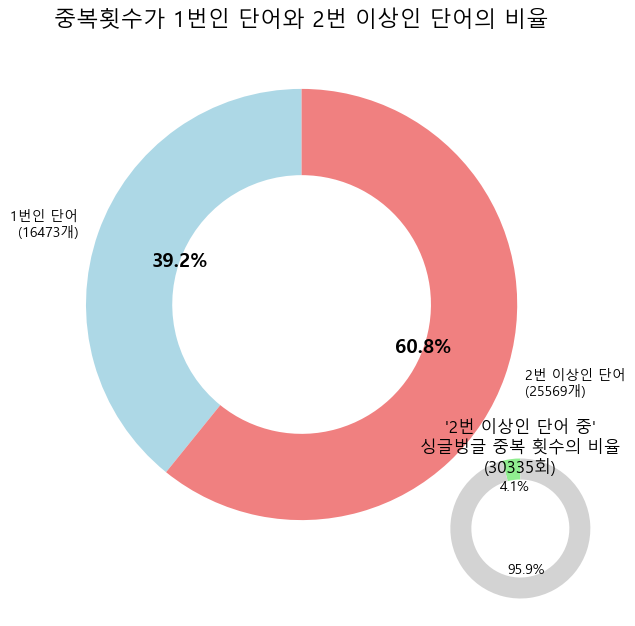

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 읽기
df_v = pd.read_csv('df_sort_by_view_count.csv')

# 중복횟수가 1인 단어와 2번 이상인 단어 분리
count_1 = len(df_v[df_v['중복횟수'] == 1])  
count_above_1_df = df_v[(df_v['중복횟수'] >= 2)]
count_above_1 = len(count_above_1_df)

# 전체 데이터 개수
total = len(df_v)

# '싱글벙글' 단어에 대한 필터링
single_df = df_v[(df_v['명사'] == '싱글벙글')]
single_count = single_df['중복횟수'].sum()  # 중복횟수의 총합
singl_bungle_ratio = single_count / count_above_1_df['중복횟수'].sum()  # 비율 계산

# 비율 계산 (전체 개수로 나누어서 비율 구하기)
count_1_ratio = count_1 / total
count_above_1_ratio = count_above_1 / total  # 2번 이상에서 1번인 단어를 제외한 비율

# 원형 그래프에 사용할 데이터
labels = [f'1번인 단어\n({count_1}개)', f'2번 이상인 단어\n({count_above_1}개)']
sizes = [count_1_ratio, count_above_1_ratio]
colors = ['lightblue', 'lightcoral']

# 도넛 그래프 그리기
fig, ax = plt.subplots(figsize=(7, 7))

# 원형 그래프 그리기 (중앙을 비우기 위해 "wedgeprops" 사용)
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=0.4))

# 그래프 숫자 위치 조정 및 볼드 처리
for autotext in autotexts:
    autotext.set_fontsize(14)  # 글씨 크기 조정
    autotext.set_fontweight('bold')  # 글씨 두껍게
    autotext.set_color('black')  # 글씨 색상 검정으로 설정

# '싱글벙글' 비율을 나타내는 부가적인 원형 그래프 그리기 (외각에 추가)
ax_inset = fig.add_axes([0.7, 0.05, 0.25, 0.25])  # 위치를 오른쪽 아래로 조정 (x, y, width, height)
ax_inset.pie(
    [singl_bungle_ratio, 1 - singl_bungle_ratio],
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightgreen', 'lightgray'],
    wedgeprops=dict(width=0.3)
)

# 부가적인 원형 그래프에 이름 텍스트 추가
ax_inset.text(0, 1.15, f"'2번 이상인 단어 중'\n싱글벙글 중복 횟수의 비율\n({single_count}회)", ha='center', va='center', fontsize=12)

# 그래프 타이틀 설정
ax.set_title("중복횟수가 1번인 단어와 2번 이상인 단어의 비율", fontsize=16)

# 차트 출력
plt.show()


In [38]:
import pandas as pd
import plotly.express as px

# 데이터프레임 읽기
df_v = pd.read_csv('df_sort_by_view_count.csv')


# head 가 순서대로 정렬된 데이터를 가져오지 않음
# 그래서 결국 재정렬해야함
top_duplicate = df_v.nlargest(20, '중복횟수')


fig_duplicate = px.bar(
    top_duplicate ,
    x='명사',
    y='중복횟수',
    title="중복횟수가 높은 20개 단어(1~19)",
    labels={'명사': '단어', '중복횟수': '중복횟수'}
)
fig_duplicate.show()





In [37]:
import pandas as pd
import plotly.express as px

# 데이터프레임 읽기
df_v = pd.read_csv('df_sort_by_view_count.csv')


# head 가 순서대로 정렬된 데이터를 가져오지 않음
# 그래서 결국 재정렬해야함
top_duplicate = df_v.nlargest(41, '중복횟수')

top_10_41_duplicate = top_duplicate[9:41]

fig_duplicate = px.bar(
    top_10_41_duplicate,
    x='명사',
    y='중복횟수',
    title="중복횟수가 높은 40개 단어(10~41)",
    labels={'명사': '단어', '중복횟수': '중복횟수'}
)
fig_duplicate.show()



In [40]:
import pandas as pd
import plotly.express as px

# 데이터프레임 읽기
df_v = pd.read_csv('df_sort_by_view_count.csv')


# head 가 순서대로 정렬된 데이터를 가져오지 않음
# 그래서 결국 재정렬해야함
top_duplicate = df_v.nlargest(500, '중복횟수')

top_20_40_duplicate = top_duplicate[1:500]


fig_duplicate = px.bar(
    top_20_40_duplicate,
    x='명사',
    y='중복횟수',
    title="중복횟수가 높은 500개 단어(1등 싱글벙글 제외)",
    labels={'명사': '단어', '중복횟수': '중복횟수'}
)
fig_duplicate.show()

In [42]:
import pandas as pd
import plotly.express as px

# 데이터프레임 읽기
df_w = pd.read_csv('df_sort_by_word_count.csv')
df_v = pd.read_csv('df_sort_by_view_count.csv')


df_v['평균조회수'] = df_v['총조회수'] / df_v['중복횟수']
df_v['평균천수'] = df_v['총추천수'] / df_v['중복횟수']


df_w['평균조회수'] = df_w['총조회수'] / df_w['중복횟수']
df_w['평균추천수'] = df_w['총추천수'] / df_w['중복횟수']

top_viewed = df_v.nlargest(40, '평균조회수')
row_viewed = df_v.nsmallest(40, '평균조회수')

# 1. 평균추천수가 가장 높은 40개 명사 (평균 추천수 상위 40 기준으로 정렬)
top_recommended = df_w.nlargest(40, '평균추천수')
row_recommended = df_w.nsmallest(40, '평균추천수')



fig_recommended = px.bar(
    top_recommended,
    x='명사',
    y='평균추천수',
    title="평균추천수가 높은 40개 단어",
    labels={'명사': '단어', '평균추천수': '평균추천수'}
)
fig_recommended.show()

fig_recommended = px.bar(
    row_recommended,
    x='명사',
    y='평균추천수',
    title="평균추천수가 낮은 40개 단어",
    labels={'명사': '단어', '평균추천수': '평균추천수'}
)
fig_recommended.show()


fig_viewed = px.bar(
    top_viewed,
    x='명사',
    y='평균조회수',
    title="평균조회수가 높은 40개 단어",
    labels={'명사': '단어', '평균조회수': '평균조회수'}
)
fig_viewed.show()


fig_viewed = px.bar(
    row_viewed,
    x='명사',
    y='평균조회수',
    title="평균조회수가 낮은 40개 단어",
    labels={'명사': '단어', '평균조회수': '평균조회수'}
)
fig_viewed.show()

In [43]:
# 총 긍정도
import pandas as pd
import plotly.express as px

# 데이터프레임 읽기
df = pd.read_csv('dcinside_new_data.csv')


# '긍정'이 1인 것과 0인 것의 비율 계산
positive_count = df[df['긍정'] == 1].shape[0]  # 긍정이 1인 경우
negative_count = df[df['긍정'] == 0].shape[0]  # 긍정이 0인 경우

# 긍정과 부정 비율 데이터프레임 생성
data = {
    '긍정/부정': ['긍정', '부정'],
    '비율': [positive_count, negative_count]
}

df_pie = pd.DataFrame(data)

# 원형 차트 생성
fig = px.pie(df_pie, 
             names='긍정/부정', 
             values='비율', 
             title="실시간베스트글의 긍정/부정 비율",
             color='긍정/부정', 
             color_discrete_map={'긍정': 'lightgreen', '부정': 'lightcoral'})

# 차트 출력
fig.show()


In [44]:
import pandas as pd
import plotly.express as px

# 데이터프레임 읽기
df = pd.read_csv('dcinside_new_data.csv')

# '갤러리'가 '싱갤'인 데이터만 필터링
df_singgal = df[df['갤러리'] == '싱갤']

# 전체 글 수
total_count_singgal = df_singgal.shape[0]

# '긍정'이 1인 것과 0인 것의 비율 계산
positive_count_singgal = df_singgal[df_singgal['긍정'] == 1].shape[0]  # 긍정이 1인 경우
negative_count_singgal = df_singgal[df_singgal['긍정'] == 0].shape[0]  # 긍정이 0인 경우

# 비율 계산
positive_ratio_singgal = positive_count_singgal / total_count_singgal
negative_ratio_singgal = negative_count_singgal / total_count_singgal

# 긍정과 부정 비율 데이터프레임 생성
data_singgal = {
    '긍정/부정': ['긍정', '부정'],
    '비율': [positive_ratio_singgal, negative_ratio_singgal]
}

df_pie_singgal = pd.DataFrame(data_singgal)

# 원형 차트 생성
fig_singgal = px.pie(df_pie_singgal, 
             names='긍정/부정', 
             values='비율', 
             title="싱갤의 긍정/부정 비율",
             color='긍정/부정', 
             color_discrete_map={'긍정': 'lightgreen', '부정': 'lightcoral'})

# 차트 출력
fig_singgal.show()

# '갤러리'가 '야갤'인 데이터만 필터링
df_singgal2 = df[df['갤러리'] == '야갤']

# 전체 글 수
total_count_singgal2 = df_singgal2.shape[0]

# '긍정'이 1인 것과 0인 것의 비율 계산
positive_count_singgal2 = df_singgal2[df_singgal2['긍정'] == 1].shape[0]  # 긍정이 1인 경우
negative_count_singgal2 = df_singgal2[df_singgal2['긍정'] == 0].shape[0]  # 긍정이 0인 경우

# 비율 계산
positive_ratio_singgal2 = positive_count_singgal2 / total_count_singgal2
negative_ratio_singgal2 = negative_count_singgal2 / total_count_singgal2

# 긍정과 부정 비율 데이터프레임 생성
data_singgal2 = {
    '긍정/부정': ['긍정', '부정'],
    '비율': [positive_ratio_singgal2, negative_ratio_singgal2]
}

df_pie_singgal2 = pd.DataFrame(data_singgal2)

# 원형 차트 생성
fig_singgal2 = px.pie(df_pie_singgal2, 
             names='긍정/부정', 
             values='비율', 
             title="야갤의 긍정/부정 비율",
             color='긍정/부정', 
             color_discrete_map={'긍정': 'lightgreen', '부정': 'lightcoral'})

# 차트 출력
fig_singgal2.show()


In [45]:
import pandas as pd
import plotly.express as px

# 데이터프레임 읽기
df = pd.read_csv('dcinside_new_data.csv')

# 각 갤러리별 글의 중복 횟수 계산
gallery_counts = df['갤러리'].value_counts()

# 중복이 100번 이상인 갤러리들만 선택
filtered_galleries = gallery_counts[gallery_counts >= 100].index

# 중복 100번 이상인 데이터만 필터링
df_filtered = df[df['갤러리'].isin(filtered_galleries)]

# 각 갤러리별 긍정과 부정 개수 계산
gallery_grouped = df_filtered.groupby('갤러리')['긍정'].value_counts().unstack(fill_value=0)

# 긍정 비율 계산 (긍정의 개수 / 총 개수)
gallery_grouped['긍정비율'] = gallery_grouped[1] / (gallery_grouped[0] + gallery_grouped[1])

# 각 갤러리의 전체 글 수 (긍정 + 부정)
gallery_grouped['전체글수'] = gallery_grouped[0] + gallery_grouped[1]

# 긍정 비율이 높은 갤러리 10개 선택
top_10_positive_galleries = gallery_grouped['긍정비율'].nlargest(30)

# 상위 10개 갤러리의 이름, 긍정 비율, 전체 글 수를 데이터프레임으로 변환
top_10_galleries_df = top_10_positive_galleries.reset_index()

# 전체 글 수 컬럼을 다시 추가
top_10_galleries_df['전체글수'] = top_10_galleries_df['갤러리'].map(gallery_grouped['전체글수'])

# 막대그래프 생성
fig = px.bar(top_10_galleries_df, 
             x='갤러리', 
             y='긍정비율', 
             title='긍정 비율이 가장 높은 30개 갤러리 (표본글 100개 이상)',
             labels={'긍정비율': '긍정 비율', '갤러리': '갤러리'},
             text='전체글수',  # 막대 위에 전체 글 수 표시
             hover_data=['전체글수'])  # Hover 시 전체 글 수 표시

# 퍼센트 형태로 표시
fig.update_traces(texttemplate='%{text}', textposition='outside')

# y축을 백분율로 표시
fig.update_yaxes(tickformat='.2%', title_text='긍정 비율')

# 그래프 출력
fig.show()


In [47]:
import pandas as pd
import plotly.express as px

# 데이터프레임 읽기
df = pd.read_csv('dcinside_new_data.csv')

# 각 갤러리별 글의 중복 횟수 계산 및 상위 30개 갤러리 선택
top_30_galleries = df['갤러리'].value_counts().nlargest(30).index

# 상위 30개 갤러리만 필터링
df_top_30 = df[df['갤러리'].isin(top_30_galleries)]

# 각 갤러리별 긍정과 부정 개수 계산 및 긍정/부정 비율 추가
gallery_grouped = df_top_30.groupby('갤러리')['긍정'].value_counts().unstack(fill_value=0)
gallery_grouped['전체글수'] = gallery_grouped.sum(axis=1)
gallery_grouped['긍정비율'] = gallery_grouped[1] / gallery_grouped['전체글수']
gallery_grouped['부정비율'] = gallery_grouped[0] / gallery_grouped['전체글수']

# 긍정 비율과 부정 비율 데이터를 함께 변환
gallery_grouped_melted = gallery_grouped[['긍정비율', '부정비율', '전체글수']].reset_index().melt(
    id_vars=['갤러리', '전체글수'], 
    value_vars=['긍정비율', '부정비율'], 
    var_name='비율종류', 
    value_name='비율'
)

# 그래프 생성 (긍정/부정 비율 함께 표시)
fig = px.bar(gallery_grouped_melted, 
             x='갤러리', 
             y='비율', 
             color='비율종류', 
             barmode='group',  # 막대를 나란히 배치
             title='채택 횟수가 높은 30개 갤러리의 긍정/부정 비율 (전체 글 수 많은 순)',
             labels={'비율': '비율', '갤러리': '갤러리', '비율종류': '비율 종류'},
             text='전체글수',  # 막대 위에 전체 글 수 표시
             hover_data=['전체글수'])  # Hover 시 전체 글 수 표시

# y축을 백분율로 표시
fig.update_yaxes(tickformat='.2%', title_text='비율')

# 그래프 출력
fig.show()


In [ ]:
# 시간에 따른 채택 횟수가 높은 30개 갤러리의 긍정/부정 비율 변화 
import pandas as pd
import plotly.express as px

# 데이터프레임 읽기
df = pd.read_csv("dcinside_new_data.csv")
df = df.dropna()  # 결측값이 있는 행 삭제

# 작성날짜 포맷 수정 (월.일 -> 24.월.일로 수정)
def fix_date_format(date):
    if ':' in date:  # 시간(:)이 포함된 경우
        return "24." + date.split()[0][2:]  # "24.11.12" 형식으로 변경
    elif len(date) == 5:  # "월.일" 형식일 경우
        return "24." + date
    return date

df['작성날짜'] = df['작성날짜'].apply(fix_date_format)

# 작성날짜를 '년.월.일' 형식으로 변환, errors='coerce'를 추가하여 변환할 수 없는 값은 NaT로 처리
df['작성날짜'] = pd.to_datetime(df['작성날짜'], format='%y.%m.%d', errors='coerce')

# 상위 30개 갤러리 선택 (조회수 순으로)
top_30_galleries = df['갤러리'].value_counts().nlargest(30).index

# 상위 30개 갤러리만 필터링
df_top_30 = df[df['갤러리'].isin(top_30_galleries)]

# 긍정/부정 비율 계산
grouped = (
    df_top_30.groupby(['작성날짜', '갤러리', '긍정'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={0: '부정', 1: '긍정'}))
grouped['전체글수'] = grouped['긍정'] + grouped['부정']
grouped['긍정비율'] = grouped['긍정'] / grouped['전체글수']
grouped['부정비율'] = grouped['부정'] / grouped['전체글수']

# 애니메이션 그래프 생성
fig = px.bar(
    grouped,
    x='갤러리',
    y=['긍정비율', '부정비율'],  # 긍정 비율과 부정 비율을 별도의 컬럼으로 표현
    color_discrete_map={'긍정비율': 'lightblue', '부정비율': 'lightcoral'},  # 색상 지정
    animation_frame='작성날짜',  # 날짜별 애니메이션
    title='채택 횟수가 높은 30개 갤러리의 긍정/부정 비율 변화',
    labels={'count': '비율', '갤러리': '갤러리 이름'},
    height=600,
    text='전체글수',  # 각 막대에 총 글 수 표시
    category_orders={'갤러리': top_30_galleries.tolist()}  # X축의 갤러리 순서 고정
)

# 그래프의 텍스트로 총 글 수를 추가
fig.update_traces(texttemplate='%{text}', textposition='outside')

# 레이아웃 및 Y축 설정
fig.update_layout(
    xaxis_title='갤러리',
    yaxis_title='긍정/부정 비율',
    barmode='group',  # 막대 그래프를 나란히 배치
    legend_title='비율 유형',
    yaxis=dict(
        tickformat='.2%',  # 긍정 비율 표시
    ),
    yaxis2=dict(
        tickformat='.2%',
        overlaying='y',
        side='right',  # 오른쪽에 두 번째 Y축
        showgrid=False,
    ),
)

# 그래프를 HTML 파일로 저장 (웹에서 열 수 있도록)
fig.write_html("yes_or_no_ratio.html")

# 그래프 출력
fig.show()
